In [ ]:
# Clean up any existing installations
!rm -rf spark-3.4.1-bin-hadoop3 spark-3.4.1-bin-hadoop3.tgz

# Install Java and download Spark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar -xvzf spark-3.4.1-bin-hadoop3.tgz > /dev/null

# Install dependencies
!pip install -q findspark pyspark

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# Initialize findspark
import findspark
findspark.init()


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("EmployeeML").getOrCreate()


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("EmployeeML") \
    .getOrCreate()


In [ ]:
from google.colab import files
uploaded = files.upload()



Saving employees.csv to employees.csv


In [ ]:
df = spark.read.csv("employees.csv", header=True, inferSchema=True)
df.show()
df.printSchema()


+------+---------+------+---+----------+
|Emp_No| Emp_Name|Salary|Age|Department|
+------+---------+------+---+----------+
|   198|   Donald|  2600| 29|        IT|
|   199|  Douglas|  2600| 34|     Sales|
|   200| Jennifer|  4400| 36| Marketing|
|   201|  Michael| 13000| 32|        IT|
|   202|      Pat|  6000| 39|        HR|
|   203|    Susan|  6500| 36| Marketing|
|   204|  Hermann| 10000| 29|   Finance|
|   205|  Shelley| 12008| 33|   Finance|
|   206|  William|  8300| 37|        IT|
|   100|   Steven| 24000| 39|        IT|
|   101|    Neena| 17000| 27|     Sales|
|   102|      Lex| 17000| 37| Marketing|
|   103|Alexander|  9000| 39| Marketing|
|   104|    Bruce|  6000| 38|        IT|
|   105|    David|  4800| 39|        IT|
|   106|    Valli|  4800| 38|     Sales|
|   107|    Diana|  4200| 35|     Sales|
|   108|    Nancy| 12008| 28|     Sales|
|   109|   Daniel|  9000| 35|        HR|
|   110|     John|  8200| 31| Marketing|
+------+---------+------+---+----------+
only showing top

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Encode department
indexer = StringIndexer(inputCols=["Department"], outputCols=["Department_Index"])

# Assemble features
assembler = VectorAssembler(inputCols=["Salary", "Age", "Department_Index"], outputCol="features")

# Combine in pipeline
pipeline = Pipeline(stages=[indexer, assembler])
data = pipeline.fit(df).transform(df)

data.select("features").show(truncate=False)


+------------------+
|features          |
+------------------+
|[2600.0,29.0,2.0] |
|[2600.0,34.0,0.0] |
|[4400.0,36.0,3.0] |
|[13000.0,32.0,2.0]|
|[6000.0,39.0,4.0] |
|[6500.0,36.0,3.0] |
|[10000.0,29.0,1.0]|
|[12008.0,33.0,1.0]|
|[8300.0,37.0,2.0] |
|[24000.0,39.0,2.0]|
|[17000.0,27.0,0.0]|
|[17000.0,37.0,3.0]|
|[9000.0,39.0,3.0] |
|[6000.0,38.0,2.0] |
|[4800.0,39.0,2.0] |
|[4800.0,38.0,0.0] |
|[4200.0,35.0,0.0] |
|[12008.0,28.0,0.0]|
|[9000.0,35.0,4.0] |
|[8200.0,31.0,3.0] |
+------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(data)
pca_result = pca_model.transform(data)
pca_result.select("pca_features").show(truncate=False)


+-----------------------------------------+
|pca_features                             |
+-----------------------------------------+
|[-2600.001515612785,-28.910939311578687] |
|[-2600.001729864705,-33.85236906670079]  |
|[-4400.001890213133,-35.84363517039479]  |
|[-13000.00165291673,-31.373628676218917] |
|[-6000.00206114038,-38.78824123736005]   |
|[-6500.001887047587,-35.7353821209879]   |
|[-10000.001484099848,-28.501191308858264]|
|[-12008.001685047566,-32.3960803800769]  |
|[-8300.001914969753,-36.613908818205886] |
|[-24000.001993290818,-37.80378820425155] |
|[-17000.00135120258,-26.112863131556246] |
|[-17000.001922213498,-36.19371677547348] |
|[-9000.002036260017,-38.605309147682625] |
|[-6000.001969430425,-37.73207158336202]  |
|[-4800.002022232955,-38.79353037025741]  |
|[-4800.001930523001,-37.737360716259374] |
|[-4200.001778446505,-34.76949045438699]  |
|[-12008.001409721182,-27.36979599623779] |
|[-9000.001852643587,-34.63519441784154]  |
|[-8200.001629516773,-30.6497491

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=3, featuresCol="pca_features", predictionCol="cluster")
model = kmeans.fit(pca_result)
clustered = model.transform(pca_result)
clustered.select("Emp_Name", "Salary", "Age", "Department", "cluster").show()


+---------+------+---+----------+-------+
| Emp_Name|Salary|Age|Department|cluster|
+---------+------+---+----------+-------+
|   Donald|  2600| 29|        IT|      1|
|  Douglas|  2600| 34|     Sales|      1|
| Jennifer|  4400| 36| Marketing|      1|
|  Michael| 13000| 32|        IT|      0|
|      Pat|  6000| 39|        HR|      1|
|    Susan|  6500| 36| Marketing|      1|
|  Hermann| 10000| 29|   Finance|      0|
|  Shelley| 12008| 33|   Finance|      0|
|  William|  8300| 37|        IT|      0|
|   Steven| 24000| 39|        IT|      2|
|    Neena| 17000| 27|     Sales|      0|
|      Lex| 17000| 37| Marketing|      0|
|Alexander|  9000| 39| Marketing|      0|
|    Bruce|  6000| 38|        IT|      1|
|    David|  4800| 39|        IT|      1|
|    Valli|  4800| 38|     Sales|      1|
|    Diana|  4200| 35|     Sales|      1|
|    Nancy| 12008| 28|     Sales|      0|
|   Daniel|  9000| 35|        HR|      0|
|     John|  8200| 31| Marketing|      0|
+---------+------+---+----------+-

In [ ]:
from pyspark.sql.functions import when

median_salary = df.approxQuantile("Salary", [0.5], 0.0)[0]
df = df.withColumn("Attrition", when(df["Salary"] < median_salary, 1).otherwise(0))

# Re-run preprocessing on new df
data = pipeline.fit(df).transform(df)
final_data = data.select("features", "Attrition")


In [ ]:
# Split data
train, test = final_data.randomSplit([0.7, 0.3], seed=42)

# Naive Bayes
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(featuresCol="features", labelCol="Attrition")
nb_model = nb.fit(train)
nb_preds = nb_model.transform(test)

# Gradient Boosted Trees
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="Attrition", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train)
gbt_preds = gbt_model.transform(test)

# Evaluate
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="Attrition")
print("Naive Bayes AUC:", evaluator.evaluate(nb_preds))
print("GBT AUC:", evaluator.evaluate(gbt_preds))


Naive Bayes AUC: 1.0
GBT AUC: 1.0


In [ ]:
import pandas as pd

features = ["Salary", "Age", "Department_Index"]
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": gbt_model.featureImportances.toArray()
})

importance_df.sort_values(by="Importance", ascending=False)


,Feature,Importance
0,Salary,1.0
1,Age,0.0
2,Department_Index,0.0


In [ ]:
clustered_pd = clustered.select("Emp_Name", "Salary", "Age", "cluster").toPandas()
clustered_pd.to_csv("clustered_employees.csv", index=False)


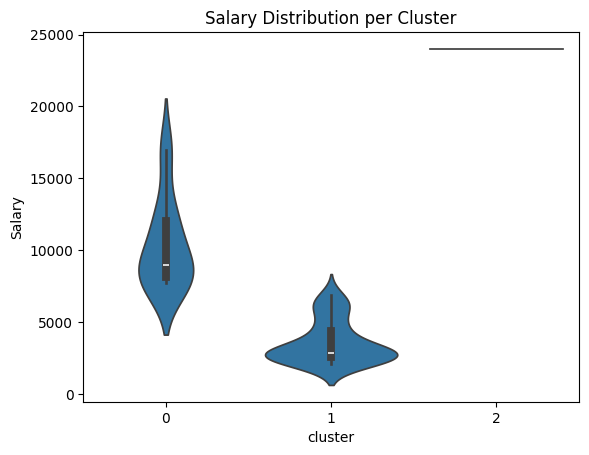

<ipython-input-14-f84a3f314037>:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x="Age", hue="cluster", fill=True)


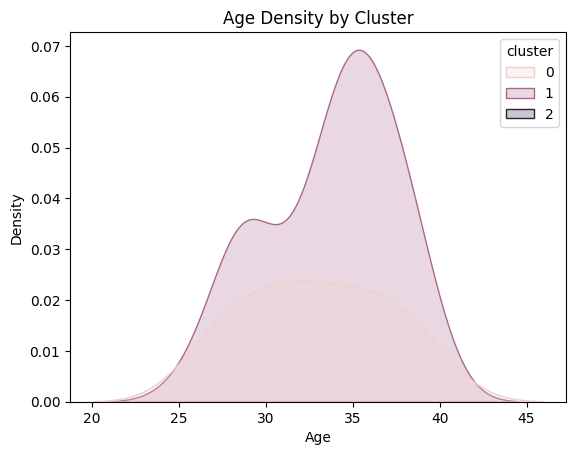

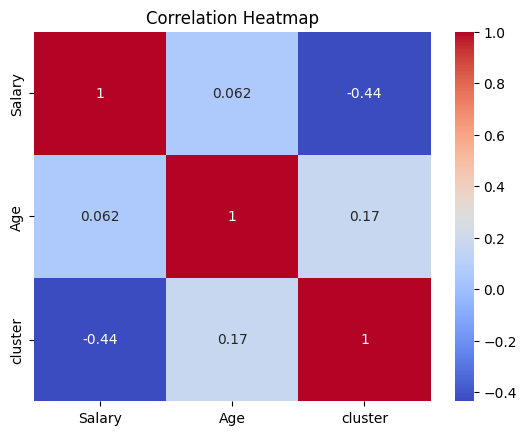

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("clustered_employees.csv")

# Violin plot: Salary vs Cluster
sns.violinplot(x="cluster", y="Salary", data=df)
plt.title("Salary Distribution per Cluster")
plt.show()

# KDE plot: Age per Cluster
sns.kdeplot(data=df, x="Age", hue="cluster", fill=True)
plt.title("Age Density by Cluster")
plt.show()

# Correlation heatmap
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# Reload Spark DataFrame from CSV
df_spark = spark.read.csv("employees.csv", header=True, inferSchema=True)
df_spark.printSchema()


root
 |-- Emp_No: integer (nullable = true)
 |-- Emp_Name: string (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Department: string (nullable = true)



In [ ]:
from pyspark.sql.functions import col

df_spark = df_spark.withColumn("Salary", col("Salary").cast("double"))
df_spark = df_spark.withColumn("Age", col("Age").cast("double"))


In [ ]:
from pyspark.sql.functions import when

# Create 'Attrition' column based on median salary
median_salary = df_spark.approxQuantile("Salary", [0.5], 0.0)[0]
df_spark = df_spark.withColumn("Attrition", when(col("Salary") < median_salary, 1).otherwise(0))

# Group by Department and calculate average Attrition
dept_attrition = df_spark.groupBy("Department") \
                         .agg({"Attrition": "avg"}) \
                         .withColumnRenamed("avg(Attrition)", "AttritionRate")

dept_attrition.show()

# Convert to Pandas for plotting
dept_attrition_pd = dept_attrition.toPandas()


+----------+------------------+
|Department|     AttritionRate|
+----------+------------------+
|     Sales|0.6153846153846154|
|        HR|             0.375|
|   Finance|               0.6|
| Marketing|0.3333333333333333|
|        IT|               0.4|
+----------+------------------+



<ipython-input-20-895e9f7c2abc>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dept_attrition_pd, x="Department", y="AttritionRate", palette="Blues_d")


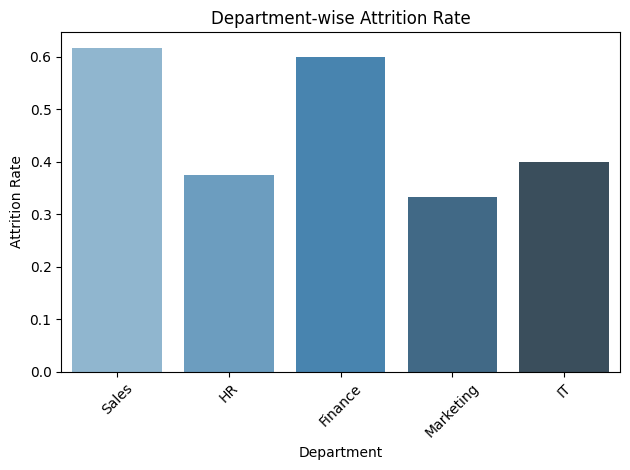

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar chart of attrition rate by department
sns.barplot(data=dept_attrition_pd, x="Department", y="AttritionRate", palette="Blues_d")
plt.title("Department-wise Attrition Rate")
plt.xticks(rotation=45)
plt.ylabel("Attrition Rate")
plt.xlabel("Department")
plt.tight_layout()
plt.show()


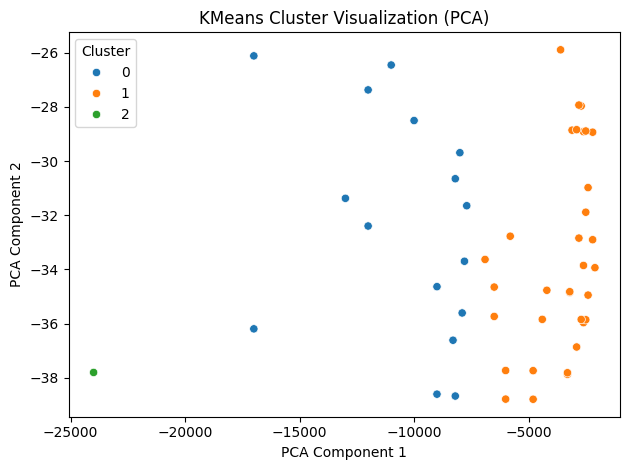

In [ ]:
# Convert Spark DataFrame to Pandas
pca_clustered = clustered.select("pca_features", "cluster").toPandas()

# Extract PCA components into x, y
pca_clustered[["x", "y"]] = pca_clustered["pca_features"].apply(lambda v: pd.Series([v[0], v[1]]))

# Plot clusters
sns.scatterplot(data=pca_clustered, x="x", y="y", hue="cluster", palette="tab10")
plt.title("KMeans Cluster Visualization (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


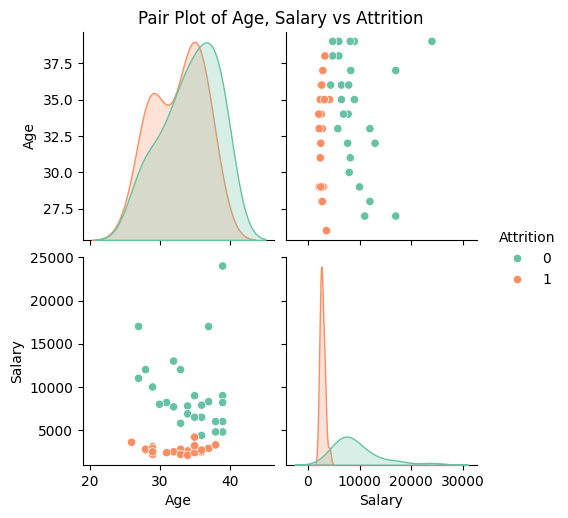

In [ ]:
# Select key columns and convert to Pandas
pair_df = df_spark.select("Age", "Salary", "Attrition").toPandas()

# Convert Attrition to categorical
pair_df["Attrition"] = pair_df["Attrition"].astype("category")

# Pair plot
sns.pairplot(pair_df, hue="Attrition", diag_kind="kde", palette="Set2")
plt.suptitle("Pair Plot of Age, Salary vs Attrition", y=1.02)
plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler

# Add binary flag: High salary
df_spark = df_spark.withColumn("HighSalary", when(col("Salary") > median_salary, 1).otherwise(0))

# Add interaction term: Age * Salary
df_spark = df_spark.withColumn("AgeSalary_Interaction", col("Age") * col("Salary"))

# Assemble new features
assembler = VectorAssembler(
    inputCols=["Age", "Salary", "HighSalary", "AgeSalary_Interaction"],
    outputCol="features_fe"
)

df_fe = assembler.transform(df_spark).select("features_fe", "Attrition")


In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Train/test split
train_fe, test_fe = df_fe.randomSplit([0.7, 0.3], seed=42)

# Train GBT model
gbt = GBTClassifier(featuresCol="features_fe", labelCol="Attrition", maxIter=10)
gbt_model = gbt.fit(train_fe)

# Predict
predictions = gbt_model.transform(test_fe)

# Evaluate
evaluator = BinaryClassificationEvaluator(labelCol="Attrition")
auc = evaluator.evaluate(predictions)
print("GBT with Feature Engineering AUC:", auc)


GBT with Feature Engineering AUC: 0.9583333333333333


<ipython-input-25-236f8b0c519c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=import_df, x="Importance", y="Feature", palette="viridis")


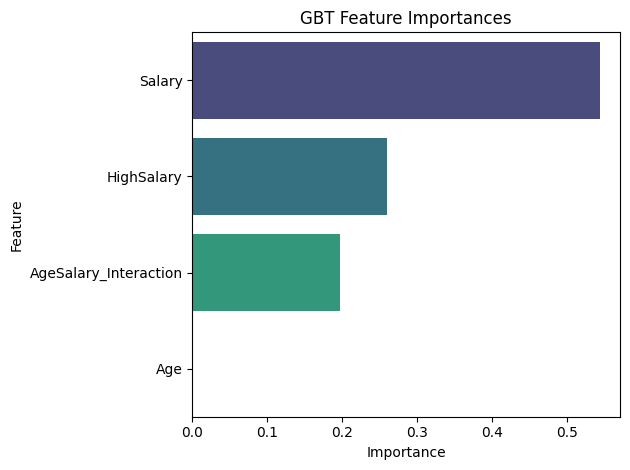

In [ ]:
# Feature names must match the assembler input
features = ["Age", "Salary", "HighSalary", "AgeSalary_Interaction"]

# Convert importances to Pandas
importances = gbt_model.featureImportances.toArray()
import_df = pd.DataFrame({"Feature": features, "Importance": importances})

# Sort and plot
import_df = import_df.sort_values(by="Importance", ascending=False)

sns.barplot(data=import_df, x="Importance", y="Feature", palette="viridis")
plt.title("GBT Feature Importances")
plt.tight_layout()
plt.show()


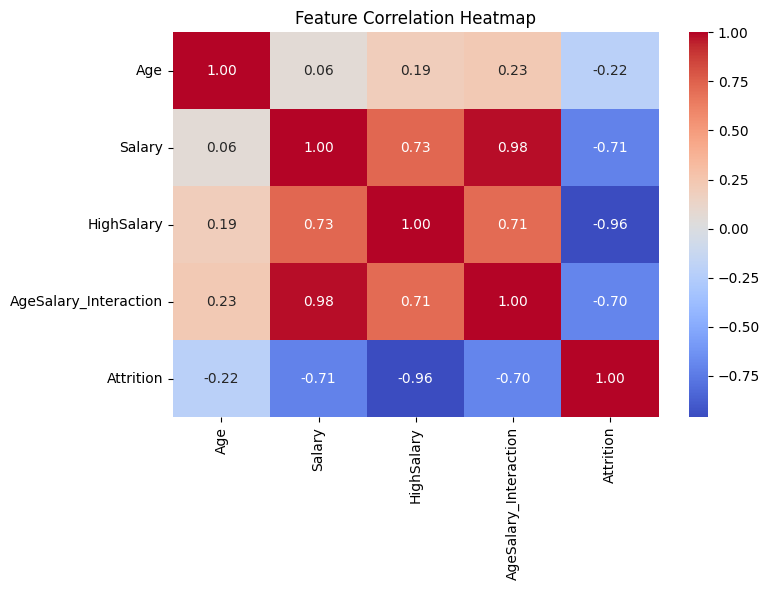

In [ ]:
# Select numeric columns only
numeric_cols = ["Age", "Salary", "HighSalary", "AgeSalary_Interaction", "Attrition"]

# Create Spark correlation matrix
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Assemble all features into vector
assembler_corr = VectorAssembler(inputCols=numeric_cols, outputCol="corr_features")
df_corr = assembler_corr.transform(df_spark).select("corr_features")

# Compute Pearson correlation
correlation_matrix = Correlation.corr(df_corr, "corr_features", "pearson").head()[0].toArray()

# Create pandas heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = pd.DataFrame(correlation_matrix, columns=numeric_cols, index=numeric_cols)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
